# Analysis and Classification of Kaggle Credit Card Fraud Dataset

<strong>By: Mateo Ismodes Sole</strong>

<strong>Dependencies</strong>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from functions import custom_kfold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, precision_recall_curve, auc, PrecisionRecallDisplay, confusion_matrix

<strong>Import Dataset</strong>

In [4]:
df_raw = pd.read_csv('./data/creditcard.csv')
df_main, df_test = train_test_split(df_raw, test_size = 0.10, random_state = 42)

## 1. Data Visualization

### 1.1 Describing Features

<p>There is a total of 31 columns, 30 of which are features and the remaining one, 'Class', is our label, which has a value of 1 when a transaction is fraudulent and a value of 0 if not. The information provided in the official Kaggle website indicates that the features named as 'V1-V28' are purposefully anonymized for security reasons. While this limits our understanding of their values, Kaggle does mention that these features are the result of performing PCA on the original dataset; thus, their original meaning has already been lost. This leaves us with two known features, i.e., 'Time' and 'Amount'. The 'Time' feature represents the number of seconds between the current transaction datum and the first transaction of the dataset. Finally, the 'Amount' feature represents the amount of money involved in the transaction.</p>

### 1.2 Balance of Classes

Proportion of Classes:
	Positive Fraud Count: 446
	Negative Fraud Count: 255880
Proportion of Positive Class: 0.173997%


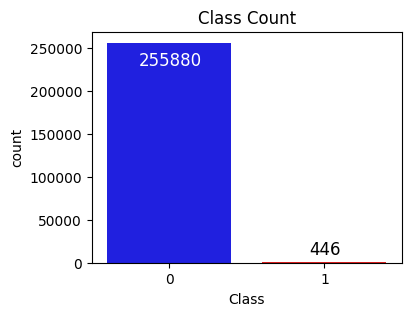

In [5]:
df_main_pos_length = len(df_main.loc[df_main['Class'] == 1])
df_main_neg_length = len(df_main.loc[df_main['Class'] == 0])

print("Proportion of Classes:")
print(f"\tPositive Fraud Count: {df_main_pos_length}")
print(f"\tNegative Fraud Count: {df_main_neg_length}")
print(f"Proportion of Positive Class: {(100 * (df_main_pos_length)/(df_main_pos_length + df_main_neg_length)):.6f}%")

plt.figure(figsize = (4, 3))
sns.countplot(data = df_main, x = 'Class', hue = 'Class', palette = ['Blue', 'Red'], legend = False)
plt.title("Class Count")
plt.annotate(df_main_neg_length, (-0.20, 230000), color = "white", fontsize = 12)
plt.annotate(df_main_pos_length, (0.9, 10000), fontsize = 12)
plt.show()

### 1.3 Null value Detection

In [6]:
null_values = df_main.isnull().sum()
null_values = null_values.rename("Null Value Count")
null_values.head(100)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
Name: Null Value Count, dtype: int64

### 1.4 Distribution Analysis and Outlier Detection

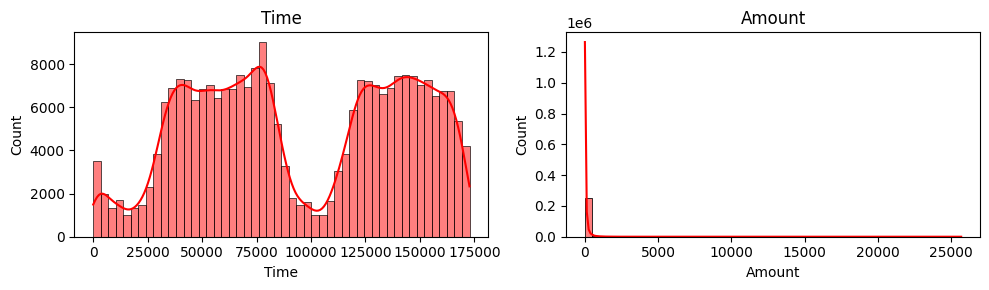

In [6]:
known_features = ['Time', 'Amount']
pca_features = list(df_main.columns.drop(['Class', 'Time', 'Amount']))

plt.figure(figsize=(10, 3))
for i, col in enumerate(known_features):
    plt.subplot(1, 2, i + 1)
    sns.histplot(df_main[col], bins=50, kde=True, color='red')
    plt.title(col)
    plt.tight_layout()
plt.show()

<p>We observe that the distribution of the 'Time' feature has two peaks that are approximately located at 'Time' = 50,000 and 'Time' = 150,000. Knowning that this is the number of seconds relative to the first data point, we can logically infer that they correspond to two different days, with the first and second peaks occuring 12 and 36 hours after the first datapoint respectively. Moreover, the increase in activity found near these peaks tells us that they most likely occur at noon. We could transform these observations into a new feature that indicates whether the transaction is made during the day or at night. This will be explored further down  in the report.</p>

<p>The distribution of the 'Amount' feature is extremely right skewed as the long right tail indicates, with most transactions occuring towards the left of the graph. The rare transactions observed to the right do fit the definition of outliers at plain sight; however, it is crucial to acknowledge that these rare values of 'Amount' could correspond to the minority class of 'Class' = 1, which accounts for just 0.17% of our dataset. For this reason, we won't be removing rows with outlier values in the 'Amount' column.</p>

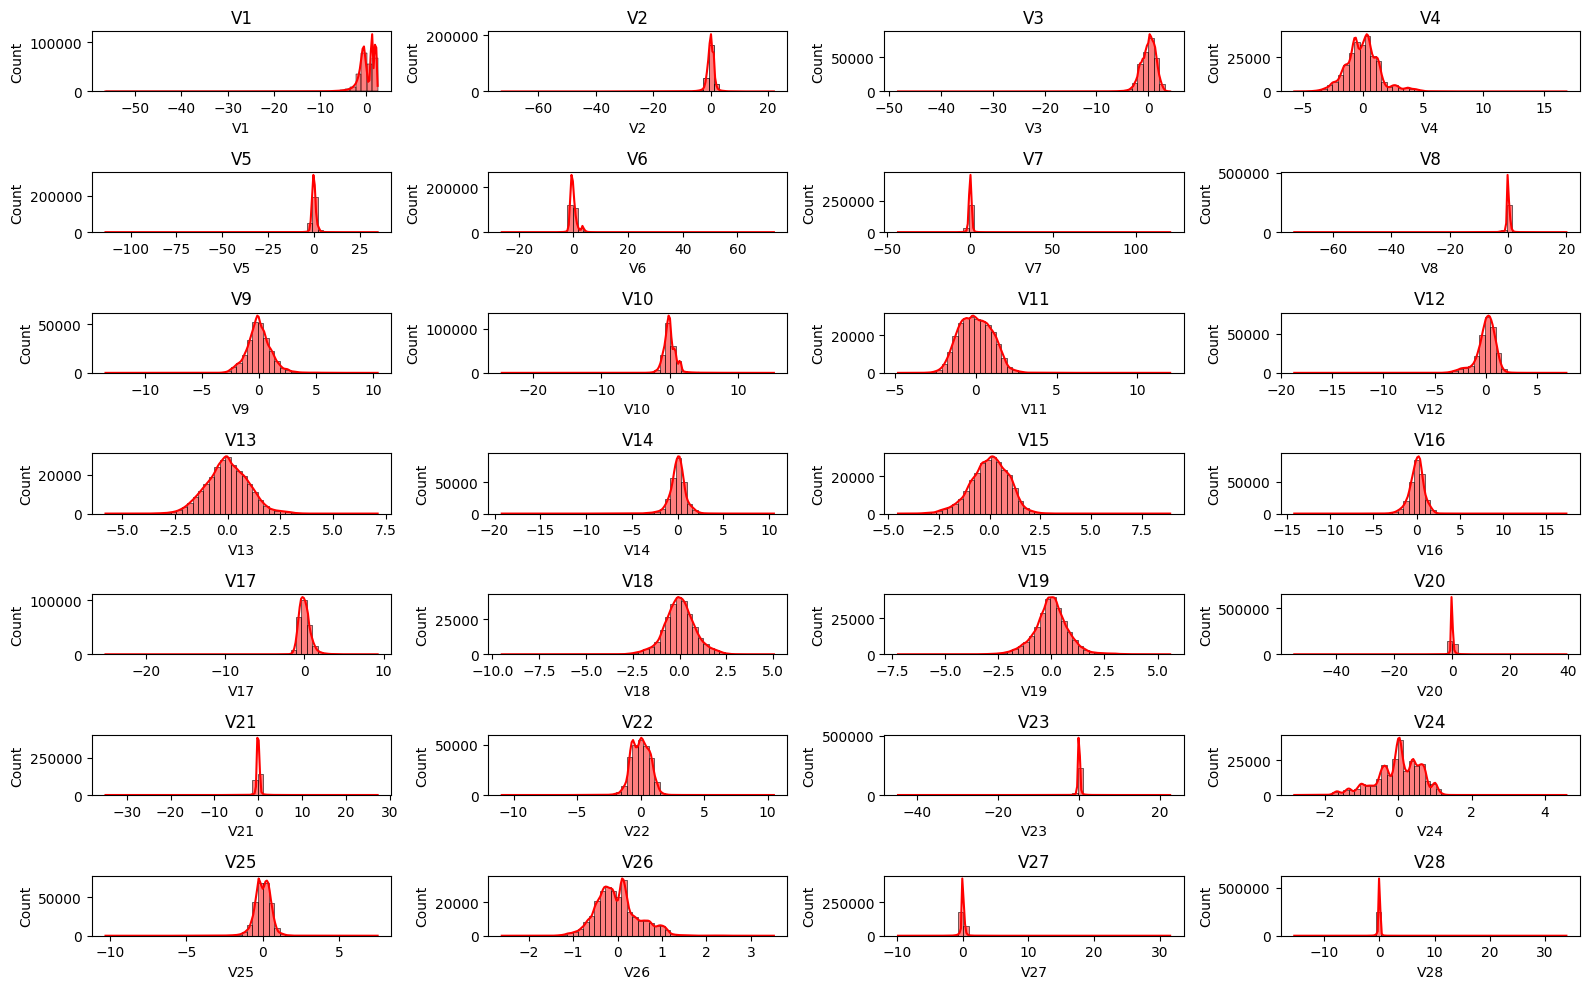

In [7]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(pca_features):
    plt.subplot(7, 4, i + 1)
    sns.histplot(df_main[col], bins=50, kde=True, color='red')
    plt.title(col)
    plt.tight_layout()
plt.show()

<p>The features 'V1-V28' all show significant kurtosis, i.e., long tails, and many are heavily skewed. Again, we observe values that would normally be removed as outliers in the long tails of the distributions presented. Aside from the plausible cause for these outliers as being part of the minority 'Class', the features 'V1-V28' are principal components of the PCA previously conducted on this data. Scaling is an important step before PCA is conducted, so we will assume that the values of features 'V1-V28' have already been scaled. For these reasons, no rows with outliers in these features will be removed and they won't be scaled any further.</p>

## 2. Data Preprocessing

<p>Before conducting any form of classification, we need to define our methodology for additional preprocessing steps, such as scaling and balancing. Defining our process at this stage is important due to the effect that both scaling and balancing can have in our training. For instance, traditional machine learning classifiers can benefit from evaluation stategies such as k-cross validation, but when used, any scaling and balancing should be done after the training and validation portions of the data have been extracted in order to avoid data leakage. However, k-cross validation allows us to determine the best hyperparameters for our classifiers, but after finding them, the classifiers need to be retrained on the entire training data. Moreover, we will also be training a neural network, for which it isn't appropriate to use k-cross validation; thus, preprocessing our dataset will still have a purpose later on in this notebook.</p>

<p>Before scaling and balancing the dataset, we have to separate the training and validation datasets. Since we already separated 10% of the data for testing, we should extract the same proportion for the validation dataset.</p>

In [91]:
# Training Dataset to be used to train classifiers after the best hyperparameters are found
df_train_cl = df_main.copy()

# Training and Validation dataset for Neural Network
eq_prop = round(len(df_test)/len(df_main), 2)
print(f"Equivalent Percentage: {eq_prop}%")

df_train_nn, df_val_nn = train_test_split(df_main, test_size = eq_prop, random_state = 42)
print(f"\tdf_val length: {len(df_val_nn)}")
print(f"\tdf_train length: {len(df_train_nn)}")

Equivalent Percentage: 0.11%
	df_val length: 28196
	df_train length: 228130


### 2.1 Scaling

In [92]:
scaler_cl = RobustScaler()
df_train_cl.loc[:, ['Time', 'Amount']] = scaler_cl.fit_transform(df_train_cl[['Time', 'Amount']])  # df_train_cl will be used to train the classifiers after the best hyperparameters are found.

scaler_nn = RobustScaler()
df_train_nn.loc[:, ['Time', 'Amount']] = scaler_nn.fit_transform(df_train_nn[['Time', 'Amount']])  # df_train_nn will be used to train the neural network.
df_val_nn.loc[:, ['Time', 'Amount']] = scaler_nn.transform(df_val_nn[['Time', 'Amount']])  # df_val_nn will be used to find the best hyperparameters of the neural network.

### 2.2 Balancing

In [93]:
def undersample_data(input_df):
    df_pos = input_df.loc[input_df.Class == 1]
    df_neg = input_df.loc[input_df.Class == 0]

    pos_class_size = len(df_pos)

    df_neg_subsample = df_neg.sample(n = pos_class_size, random_state = 42, ignore_index = True)
    df_undersampled = pd.concat([df_pos, df_neg_subsample], axis = 0)
    df_undersampled = df_undersampled.sample(n = (2 * pos_class_size), random_state = 42, ignore_index = True)

    return df_undersampled

def oversample_data(input_df):
    oversample = SMOTE()

    df_X = input_df.drop('Class', axis = 1)
    df_y = input_df.loc[:,['Class']]
    df_X_oversampled, df_y_oversampled = oversample.fit_resample(df_X, df_y)

    df_oversampled = pd.concat([df_X_oversampled, df_y_oversampled], axis = 1)
    df_oversampled = df_oversampled.sample(n = len(df_oversampled), random_state = 42, ignore_index = True)

    return df_oversampled

<p>While both undersampling and oversampling can be used to train traditional machine learning classifiers, neural networks require abundant datasets. Since undersampling limits our dataset to the size of the minority group times two, i.e. 892 data points, we will not use it to balance our neural network's training dataset.</p>

In [72]:
# Undersampling
df_train_cl_us = undersample_data(df_train_cl)

# Oversampling
df_train_cl_os = oversample_data(df_train_cl)
df_train_nn_os = oversample_data(df_train_nn)

## 3. Post Processing Visualization

### 3.1 Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix (Oversampled Data)')

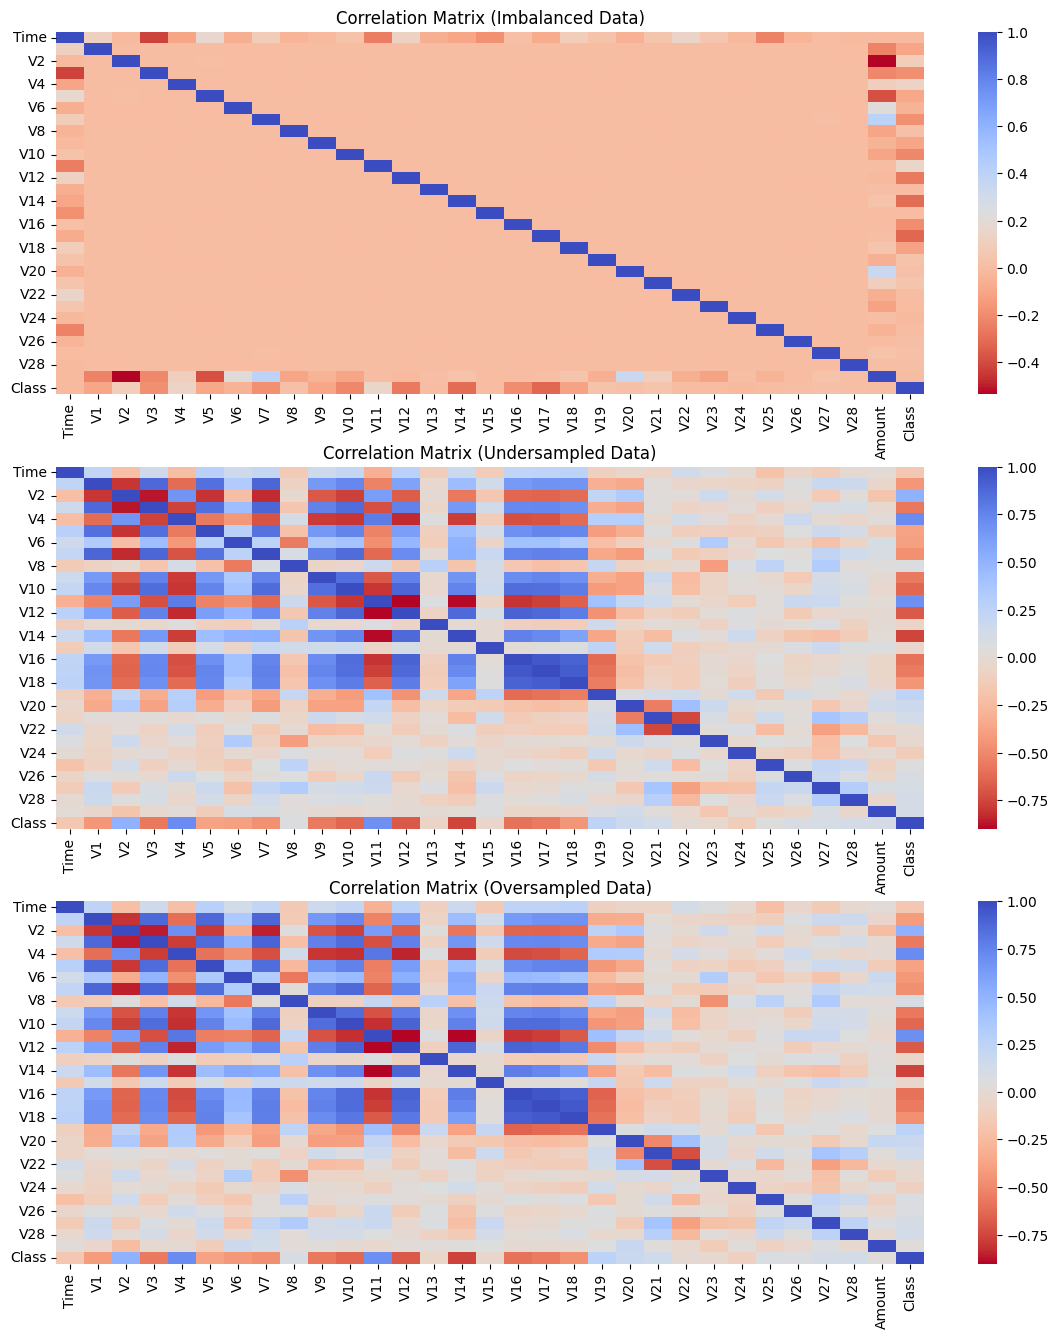

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (14, 16))

corr = df_train_cl.corr()
sns.heatmap(corr, cmap = 'coolwarm_r', annot_kws = {'size':14}, ax = ax1)
ax1.set_title("Correlation Matrix (Imbalanced Data)")

corr = df_train_cl_us.corr()
sns.heatmap(corr, cmap = 'coolwarm_r', annot_kws = {'size':14}, ax = ax2)
ax2.set_title("Correlation Matrix (Undersampled Data)")

corr = df_train_cl_os.corr()
sns.heatmap(corr, cmap = 'coolwarm_r', annot_kws = {'size':14}, ax = ax3)
ax3.set_title("Correlation Matrix (Oversampled Data)")

## 4. Classification with Traditional Models

### 4.1 Logistic Regression

<strong>Oversampling</strong>

In [14]:
param_grid = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

log_reg_search = GridSearchCV(LogisticRegression(solver = 'liblinear', max_iter = 1000), param_grid, n_jobs = -1)

scores_os, best_model_os_lr = custom_kfold(df_main, cv_n = 5, balancing_method = "over", model = log_reg_search, random_state = 42)

print(scores_os)
print(best_model_os_lr.get_params())

100%|██████████| 5/5 [11:55<00:00, 143.11s/it]

{'train': {'accuracy_lst': np.float64(0.9494266848737734), 'precision_lst': np.float64(0.9743170027478095), 'recall_lst': np.float64(0.9231685995485013), 'f1_lst': np.float64(0.9480295152566816)}, 'val': {'accuracy_lst': np.float64(0.9754647420267238), 'precision_lst': np.float64(0.06139827961357165), 'recall_lst': np.float64(0.9142023451809795), 'f1_lst': np.float64(0.11496026557636219)}}
{'C': 1000, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


<strong>Undersampling</strong>

In [18]:
param_grid = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

log_reg_search = GridSearchCV(LogisticRegression(solver = 'liblinear', max_iter = 1000), param_grid, n_jobs = -1)

scores_us, best_model_us_lr = custom_kfold(df_main, cv_n = 5, balancing_method = "under", model = log_reg_search, random_state = 42)

print(scores_us)
print(best_model_us_lr.get_params())

 20%|██        | 1/5 [00:00<00:00,  7.92it/s]/home/mat/miniconda3/envs/da_ml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 60%|██████    | 3/5 [00:07<00:04,  2.36s/it]/home/mat/miniconda3/envs/da_ml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mat/miniconda3/envs/da_ml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 80%|████████  | 4/5 [00:14<00:04,  4.30s/it]/home/mat/miniconda3/envs/da_ml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mat/miniconda3/envs/da_ml_env/lib/python3.10/site-packages/sklearn/svm/_base.py:124

{'train': {'accuracy_lst': np.float64(0.9501417452685971), 'precision_lst': np.float64(0.9854451607072413), 'recall_lst': np.float64(0.913803166560213), 'f1_lst': np.float64(0.9482340829809432)}, 'val': {'accuracy_lst': np.float64(0.9753828147859164), 'precision_lst': np.float64(0.06075650538560862), 'recall_lst': np.float64(0.9070284321375013), 'f1_lst': np.float64(0.11382212541915963)}}
{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### 4.2 K-Nearest-Neighbors

<strong>Oversampling</strong>

In [19]:
param_grid = {"n_neighbors": list(range(2, 31))}

knn_search = GridSearchCV(KNeighborsClassifier(n_jobs = -1), param_grid, n_jobs = -1)

scores_os, best_model_os_knn = custom_kfold(df_main, cv_n = 5, balancing_method = "over", model = knn_search, random_state = 42)

print(scores_os)
print(best_model_os_knn.get_params())

100%|██████████| 5/5 [1:00:09<00:00, 721.81s/it]

{'train': {'accuracy_lst': np.float64(1.0), 'precision_lst': np.float64(1.0), 'recall_lst': np.float64(1.0), 'f1_lst': np.float64(1.0)}, 'val': {'accuracy_lst': np.float64(0.9990363795962157), 'precision_lst': np.float64(0.6892370625189677), 'recall_lst': np.float64(0.8299699451057212), 'f1_lst': np.float64(0.74937784191101)}}
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}


<strong>Undersampling</strong>

In [21]:
param_grid = {"n_neighbors": list(range(2, 31))}

knn_search = GridSearchCV(KNeighborsClassifier(n_jobs = -1), param_grid, n_jobs = -1)

scores_us, best_model_us_knn = custom_kfold(df_main, cv_n = 5, balancing_method = "under", model = knn_search, random_state = 42)

print(scores_us)
print(best_model_us_knn.get_params())

100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

{'train': {'accuracy_lst': np.float64(0.9547922607552515), 'precision_lst': np.float64(0.9809895378553142), 'recall_lst': np.float64(0.9275735507814696), 'f1_lst': np.float64(0.953502878120905)}, 'val': {'accuracy_lst': np.float64(0.9725582756266459), 'precision_lst': np.float64(0.05981286755970718), 'recall_lst': np.float64(0.8872565657320252), 'f1_lst': np.float64(0.1111447809917148)}}
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}


### 4.3 Decision Tree

<strong>Oversampling</strong>

In [24]:
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_search = GridSearchCV(DecisionTreeClassifier(),param_grid, n_jobs = -1)

scores_os, best_model_os_dt = custom_kfold(df_main, cv_n = 5, balancing_method = "over", model = dt_search, random_state = 42)

print(scores_os)
print(best_model_os_dt.get_params())

100%|██████████| 5/5 [15:19<00:00, 183.99s/it]

{'train': {'accuracy_lst': np.float64(0.9999750858274314), 'precision_lst': np.float64(0.9999853440627635), 'recall_lst': np.float64(0.9999648270622832), 'f1_lst': np.float64(0.9999750853799604)}, 'val': {'accuracy_lst': np.float64(0.9975343801814104), 'precision_lst': np.float64(0.3916372557914474), 'recall_lst': np.float64(0.7466138475245004), 'f1_lst': np.float64(0.5128766241121526)}}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


<strong>Undersampling</strong>

In [25]:
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_search = GridSearchCV(DecisionTreeClassifier(),param_grid, n_jobs = -1)

scores_us, best_model_us_dt = custom_kfold(df_main, cv_n = 3, balancing_method = "under", model = dt_search, random_state = 42)

print(scores_us)
print(best_model_us_dt.get_params())

100%|██████████| 2/2 [00:00<00:00,  8.76it/s]

{'train': {'accuracy_lst': np.float64(0.9947552447552448), 'precision_lst': np.float64(1.0), 'recall_lst': np.float64(0.9895104895104896), 'f1_lst': np.float64(0.9946996466431095)}, 'val': {'accuracy_lst': np.float64(0.9130462770066243), 'precision_lst': np.float64(0.016915129743986672), 'recall_lst': np.float64(0.8469737159392332), 'f1_lst': np.float64(0.03313550801591622)}}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


### 4.4 Naive Bayes

<strong>Oversampling</strong>

In [27]:
param_grid = {'var_smoothing': np.logspace(-12, -3, 10)}

nb_search = GridSearchCV(GaussianNB(),param_grid, n_jobs = -1)

scores_os, best_model_os_nb = custom_kfold(df_main, cv_n = 5, balancing_method = "over", model = nb_search, random_state = 42)

print(scores_os)
print(best_model_os_nb.get_params())

100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

{'train': {'accuracy_lst': np.float64(0.9148649763856198), 'precision_lst': np.float64(0.9737005964960362), 'recall_lst': np.float64(0.852764264397792), 'f1_lst': np.float64(0.9092190642728966)}, 'val': {'accuracy_lst': np.float64(0.9768536038232712), 'precision_lst': np.float64(0.06106119388076496), 'recall_lst': np.float64(0.8582059752865072), 'f1_lst': np.float64(0.11399510472780013)}}
{'priors': None, 'var_smoothing': np.float64(0.001)}


<strong>Undersampling</strong>

In [28]:
param_grid = {'var_smoothing': np.logspace(-12, -3, 10)}

nb_search = GridSearchCV(GaussianNB(),param_grid, n_jobs = -1)

scores_us, best_model_us_nb = custom_kfold(df_main, cv_n = 5, balancing_method = "under", model = nb_search, random_state = 42)

print(scores_us)
print(best_model_us_nb.get_params())

100%|██████████| 5/5 [00:00<00:00, 11.81it/s]

{'train': {'accuracy_lst': np.float64(0.9169997977233425), 'precision_lst': np.float64(0.9690274579290767), 'recall_lst': np.float64(0.8615683213257037), 'f1_lst': np.float64(0.9121088527311182)}, 'val': {'accuracy_lst': np.float64(0.9695308690139471), 'precision_lst': np.float64(0.0480261488484033), 'recall_lst': np.float64(0.8631751110889763), 'f1_lst': np.float64(0.09083602160862178)}}
{'priors': None, 'var_smoothing': np.float64(0.001)}


## 5. Classification with Ensemble Models

### 5.1 Random Forest

<strong>Oversampling</strong>

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rfc_search = GridSearchCV(RandomForestClassifier(n_jobs = -1, random_state = 42), param_grid)

scores, best_model_os_rfc = custom_kfold(df_main, cv_n = 5, balancing_method = "over", model = rfc_search, random_state = 42)

print(scores_os)
print(best_model_os_rfc.get_params())

100%|██████████| 5/5 [5:27:26<00:00, 3929.23s/it]  

{'train': {'accuracy_lst': np.float64(0.9148649763856198), 'precision_lst': np.float64(0.9737005964960362), 'recall_lst': np.float64(0.852764264397792), 'f1_lst': np.float64(0.9092190642728966)}, 'val': {'accuracy_lst': np.float64(0.9768536038232712), 'precision_lst': np.float64(0.06106119388076496), 'recall_lst': np.float64(0.8582059752865072), 'f1_lst': np.float64(0.11399510472780013)}}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


<strong>Undersampling</strong>

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rfc_search = GridSearchCV(RandomForestClassifier(n_jobs = -1, random_state = 42), param_grid)

scores, best_model_us_rfc = custom_kfold(df_main, cv_n = 5, balancing_method = "under", model = rfc_search, random_state = 42)

print(scores_us)
print(best_model_us_rfc.get_params())

100%|██████████| 5/5 [02:31<00:00, 30.27s/it]

{'train': {'accuracy_lst': np.float64(0.9169997977233425), 'precision_lst': np.float64(0.9690274579290767), 'recall_lst': np.float64(0.8615683213257037), 'f1_lst': np.float64(0.9121088527311182)}, 'val': {'accuracy_lst': np.float64(0.9695308690139471), 'precision_lst': np.float64(0.0480261488484033), 'recall_lst': np.float64(0.8631751110889763), 'f1_lst': np.float64(0.09083602160862178)}}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### 5.2 XGBoost

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

xgb_search = GridSearchCV(xgb.XGBClassifier(), param_grid, n_jobs = -1)

scores_os_xgb, best_model_os_xgb = custom_kfold(df_main, cv_n = 5, balancing_method = "over", model = xgb_search, random_state = 42)

print(scores_os_xgb)
print(best_model_os_xgb.get_params())

100%|██████████| 5/5 [04:50<00:00, 58.06s/it]

{'train': {'accuracy_lst': np.float64(0.9995334681438042), 'precision_lst': np.float64(0.9990970717090715), 'recall_lst': np.float64(0.9999706883403393), 'f1_lst': np.float64(0.9995336813960496)}, 'val': {'accuracy_lst': np.float64(0.9983809616697552), 'precision_lst': np.float64(0.5260454112988249), 'recall_lst': np.float64(0.8542251786000852), 'f1_lst': np.float64(0.6472540524215509)}}
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monoto

In [12]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

xgb_search = GridSearchCV(xgb.XGBClassifier(), param_grid, n_jobs = -1)

scores_us_xgb, best_model_us_xgb = custom_kfold(df_main, cv_n = 5, balancing_method = "under", model = xgb_search, random_state = 42)

print(scores_us_xgb)
print(best_model_us_xgb.get_params())

100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

{'train': {'accuracy_lst': np.float64(0.9960575392165415), 'precision_lst': np.float64(0.9994202898550725), 'recall_lst': np.float64(0.9926881443356619), 'f1_lst': np.float64(0.9960345454155929)}, 'val': {'accuracy_lst': np.float64(0.9674319711304008), 'precision_lst': np.float64(0.047188246148247015), 'recall_lst': np.float64(0.9025470710139393), 'f1_lst': np.float64(0.08953327027229013)}}
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'mon

## 6. Classification with Neural Network

### 6.1 Dataset and Dataloader

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FraudDataset(Dataset):
    def __init__(self, df_data, oversampling = True):

        self.data_length = len(df_data)
        df_data_X = df_data.drop('Class', axis = 1)
        df_data_y = df_data.loc[:, ['Class']]

        self.num_features = df_data_X.shape[1]

        if oversampling == True:
            oversample = SMOTE()
            df_data_X, df_data_y = oversample.fit_resample(df_data_X, df_data_y)
        
        self.X_data = torch.tensor(df_data_X.values, dtype = torch.float32)
        self.y_data = torch.tensor(df_data_y['Class'].values, dtype = torch.long)
        
    def __len__(self):
        return len(self.y_data)
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]
    

batch_size = 256

trainDataset = FraudDataset(df_train_nn)
trainDataloader = DataLoader(trainDataset, batch_size = batch_size, shuffle = True)

valDataset = FraudDataset(df_val_nn, oversampling = False)
valDataloader = DataLoader(valDataset, batch_size = len(valDataset))

### 6.2 Architecture

In [78]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.nn_stack = nn.Sequential(
            nn.Linear(n_features, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(8, 2)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.nn_stack(x)
        return logits
    
n_features = trainDataset.num_features
nn_model = NeuralNetwork(n_features = n_features)
nn_model = nn_model.to(device)

print(f"Model Structure: {nn_model}\n\n")

Model Structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (nn_stack): Sequential(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)




### 6.3 Training

In [79]:


def train_one_epoch(epoch_index):
    running_loss = 0  # cumulative loss per 1000 batches
    last_loss = 0   # average loss of the last 1000 batches

    for i, data in enumerate(trainDataloader):
        inputs, labels = data

        # Send data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero out the gradients of the model's parameters

        outputs = nn_model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()  # computes the gradients for each tensor using the chain rule

        optimizer.step()  # modifies the parameters based on their gradients

        running_loss += loss.item()  # adds to cumulative loss for current batch

        # Computes average loss of the last 1000 batches
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print(f'\tbatch {i + 1}, loss {last_loss}')
            running_loss = 0

    return last_loss  # Only the average loss of the last 1000 batches is returned

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr = 0.01)

epochs = 5

best_vloss = 1_000_000

tloss_lst = []
vloss_lst = []

for epoch in range(epochs):

    # Get loss of last 1000 batches from epoch
    nn_model.train()
    last_avg_loss = train_one_epoch(epoch)

    # Test model
    nn_model.eval()

    with torch.no_grad():
        vinputs, vlabels = next(iter(valDataloader))

        # Send to device
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)

        # Get validation loss
        voutputs = nn_model(vinputs)
        vloss = (loss_fn(voutputs, vlabels)).item()

    print(f'LOSS -> train {last_avg_loss:.4f}, val {vloss}')
    tloss_lst.append(last_avg_loss)
    vloss_lst.append(vloss)

    if vloss < best_vloss:
        best_vloss = vloss
    



	batch 1000, loss 0.06867305282410234
LOSS -> train 0.0687, val 0.030238473787903786
	batch 1000, loss 0.03814009513403289
LOSS -> train 0.0381, val 0.032364703714847565
	batch 1000, loss 0.033133280670270326
LOSS -> train 0.0331, val 0.043590646237134933
	batch 1000, loss 0.0327968786265701
LOSS -> train 0.0328, val 0.04093039780855179
	batch 1000, loss 0.027617993483319878
LOSS -> train 0.0276, val 0.048156678676605225


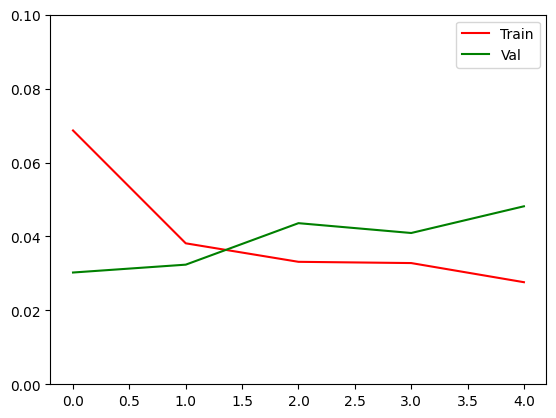

In [80]:
plt.plot(list(range(epochs)), tloss_lst, color = 'red', label = "Train")
plt.plot(list(range(epochs)), vloss_lst, color = 'green', label = "Val")
plt.legend()
plt.ylim((0, 0.1))
plt.show()

### 6.4 Validation

In [58]:
def predictDataset(model, test_dataset):

    model.eval()
    with torch.no_grad():

        test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = False)
        inputs, labels = next(iter(test_dataloader))

        inputs = inputs.to(device)

        logits = model(inputs)

        softlayer = nn.Softmax(dim = 1)
        probs = softlayer(logits).cpu().tolist()

    results = [1 if val[1] >= val[0] else 0 for val in probs]
    probs = [val[1] if val[1] >= val[0] else val[0] for val in probs]

    return results, probs, labels.tolist()

pred, prob, labels = predictDataset(model = nn_model, test_dataset = valDataset)

t_accuracy = accuracy_score(labels, pred)
t_precision = precision_score(labels, pred)
t_recall = recall_score(labels, pred)
v_precision_curve, v_recall_curve, _ = precision_recall_curve(labels, prob)
t_f1 = f1_score(labels, pred)

print("Accuracy:", t_accuracy)
print("Precision:", t_precision)
print("Recall:", t_recall)
print("F1:", t_f1)

Accuracy: 0.9974464463044403
Precision: 0.47368421052631576
Recall: 0.8181818181818182
F1: 0.6


## 7. Testing

<p>Our results show that the K-Nearest Neighbors Classifier had the highest F1-Score of 0.75, with a precision score of 0.69 and a recall score of 0.83; thus, we will proceed to evaluate the test data with this model and the hyperparameters found in section 4.2</p> 
<p>First, we will retrain this model with all of the training dataset. (Only oversampling will be considered due to drastically better results.)</p>

In [69]:
X_cl_os = df_train_cl_os.drop("Class", axis = 1)
y_cl_os = df_train_cl_os.loc[:, "Class"]

best_knn = KNeighborsClassifier(algorithm = 'auto', leaf_size = 30, metric = 'minkowski', metric_params = None, n_jobs = -1, n_neighbors = 2, p = 2, weights = 'uniform')
best_knn.fit(X_cl_os, y_cl_os)

KNeighborsClassifier(n_jobs=-1, n_neighbors=2)

In [102]:
df_test_scaled = df_test.copy()
df_test_scaled.loc[:, ['Time', 'Amount']] = scaler_cl.transform(df_test_scaled[['Time', 'Amount']])

X_test = df_test_scaled.drop("Class", axis = 1)
y_test = df_test_scaled.loc[:, "Class"]

y_test_pred = best_knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1-Score:", f1_score(y_test, y_test_pred))

Accuracy: 0.9993328885923949
Precision: 0.8
Recall: 0.782608695652174
F1-Score: 0.7912087912087912
